In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Oct  5 12:29:24 2017
This Python 3 script takes as an input the CSV files from the Kaggle Titanic Dataset (https://www.kaggle.com/c/titanic)
These CSV files contain information on Passenger ID, Ticket Price, Age, Sex, etc.
This script uses the aforementioned data to predict whether or not each passenger survived.
@author: ptm
"""
# Paul Mooney, October 2017

# see jupyter notebook for this script at the following link:
# https://www.kaggle.com/paultimothymooney/titanic-predict-pandas-matplotlib-sklearn/notebook


#	TABLE OF CONTENTS
    #a.	Part One: 75% Accuracy with a Minimal Dataset
        #i.	Load Data
        #ii.	Process Data
        #iii.	Describe Data 
        #iv.	Make Predictions 
        #v.	Submit Predictions 
    #b.	Part Two: 80% Accuracy with an Expanded Dataset
        #i.	Load Data
        #ii.	Process Data
        #iii.	Engineer Data
        #iv.  Select Features 
        #v.	Make Predictions 
        #vi.	Submit Predictions 

################################################################################

#	TABLE OF CONTENTS
    #a.	Part One: 75% Accuracy with a Minimal Dataset
        #i.	Load Data

%matplotlib inline

# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
#os.chdir('/Users/ptm/desktop/Current_working_directory')

# Import Data
#trainingData = pd.read_csv('train.csv')
#testingData = pd.read_csv('test.csv')
trainingData = pd.read_csv('../input/train.csv')
testingData = pd.read_csv('../input/test.csv')


In [2]:

# Inspect Data
def describeTheData(input):
    """ 
    describe the dataframe of interest
    """    
    print('')
    print('Column Values:')
    print('')
    print(input.columns.values)
    print('')
    print('Value Counts:')
    print('')
    print(input.info())
    print('')
    print('Null Value Counts:')
    print('')
    print(input.isnull().sum())
    print('')
    print('First Few Values:')
    print('')
    print(input.head())
    print('')
    print('Last Few Values:')
    print('')
    print(input.tail())
    print('')
#    print('Descriptive Stats:')
#    print('')
#    print(input.describe())
    return

describeTheData(trainingData)



Column Values:

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']

Value Counts:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None

Null Value Counts:

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

First F

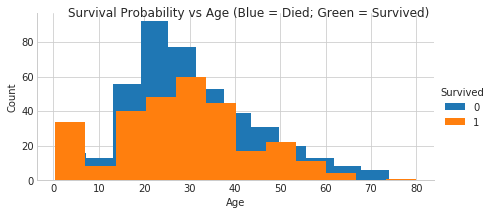

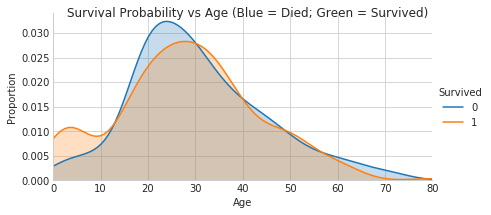

In [3]:

# Next let's take a closer look at some of the data.
# Perhaps there is a relationship between surivival probability and age?
# Let's find out by plotting the age distributions for passengers that 
# either did or did not survive the sinking of the Titanic.

def plotAgeDistribution(input):
    """ 
    This function takes a dataframe containing the train.csv data from the 
    Kaggle Titanic dataset as input and outputs a graph of Survival Probability vs Age
    """  
    sns.set_style("whitegrid")
    distributionOne = sns.FacetGrid(input, hue="Survived",aspect=2)
    distributionOne.map(plt.hist, 'Age', bins=12)
    distributionOne.add_legend()
    distributionOne.set_axis_labels('Age', 'Count')
    distributionOne.fig.suptitle('Survival Probability vs Age (Blue = Died; Green = Survived)')
    distributionTwo = sns.FacetGrid(input, hue="Survived",aspect=2)
    distributionTwo.map(sns.kdeplot,'Age',shade= True)
    distributionTwo.set(xlim=(0, input['Age'].max()))
    distributionTwo.add_legend()
    distributionTwo.set_axis_labels('Age', 'Proportion')
    distributionTwo.fig.suptitle('Survival Probability vs Age (Blue = Died; Green = Survived)')
    return
plotAgeDistribution(trainingData)


In [4]:

# It looks like passengers that were less than five years old were much more likely
# to have survived, but maybe there is not much of a correlation for any other age group.

# For the sake of simplicity, we are going to delete a bunch of columns, leaving us with 
# only the core of our dataset.  Don't worry, we will replace these missing features later, 
# in addition to also creating some new features.
trainingData = trainingData.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Embarked', 'Cabin'], axis=1)
testingData = testingData.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Embarked', 'Cabin'], axis=1)


In [5]:


#	TABLE OF CONTENTS
    #a.	Part One: 75% Accuracy with a Minimal Dataset
        #i.	Load Data
        #ii.	Process Data

# Replace Missing Values with Median Values
def replaceMissingValuesWithMedianValues(input):
    """ 
    replaces missing values from 'Fare' and 'Age' columns with median values
    """  
    input['Fare'].fillna(input['Fare'].dropna().median(), inplace=True)   
    input['Age'].fillna(input['Age'].dropna().median(), inplace=True)
    return
replaceMissingValuesWithMedianValues(trainingData)
replaceMissingValuesWithMedianValues(testingData)

# Furthermore, we will want to convert all categorical data to a numerical form in order to make our data
# more compatible with the classification algorithms that we will use later on.  In this example, we will 
# convert all of our data into numerical values that are less than five (i.e. 0,1,2,3,4). 

def sexToBinary(input):
    """ 
    Values in column 'Sex' are replaced with binary values
    """ 
    input["Sex"] = input["Sex"].astype("category")
    input["Sex"].cat.categories = [0,1]
    input["Sex"] = input["Sex"].astype("int")
    return
sexToBinary(trainingData)
sexToBinary(testingData)


def ageToCategory(input):
    """ 
    Values in column 'Sex' are replaced with {0 = "ages between 0 and 4", 1 = "ages between 4 and 12",
    2 = "ages between 12 and 18", 3 = "ages between 18 and 60", and 4 = "ages between 60 and 150"}.
    """     
    input['Age'] = input.Age.fillna(-0.5)
    bins = (-1, 4, 12, 18, 60, 150)
    categories = pd.cut(input.Age, bins, labels=False)
    input.Age = categories
    return
ageToCategory(trainingData)
ageToCategory(testingData)


def fareToCategory(input):
    """ 
    Values in column 'Sex' are replaced with {0 = "ticket price < $10", 1 = "$10<X<$20", 2 = "$20<X<$30", and 3 = "ticket price > $30".}
    """   
    input['Fare'] = input.Fare.fillna(-0.5)
    bins = (-1, 10, 20, 30, 1000)
    categories = pd.cut(input.Fare, bins, labels=False)
    input.Fare = categories
    return
fareToCategory(trainingData)
fareToCategory(testingData)


In [6]:

#	TABLE OF CONTENTS
    #a.	Part One: 75% Accuracy with a Minimal Dataset
        #i.	Load Data
        #ii.	Process Data
        #iii.	Describe Data 


# Now that we have pre-processed our data, let's take a look at it once again.  We want to answer the
# following questions: (1) What are the titles of the columns that we did not delete?; 
# (2) What does the data look like?; (3) Are there any missing values?

def describeDataAgain(input):
    """ 
    describe the dataframe of interest succinctly
    """     
    print('New summary of data after making changes:')
    print('')
    print('Column Values:')
    print('')
    print(input.columns.values)
    print('')
    print('First Few Values:')
    print('')
    print(input.head())
    print('')
    print('Null Value Counts:')
    print('')
    print(input.isnull().sum())
    return
describeDataAgain(trainingData)


New summary of data after making changes:

Column Values:

['Survived' 'Pclass' 'Sex' 'Age' 'Fare']

First Few Values:

   Survived  Pclass  Sex  Age  Fare
0         0       3    1    3     0
1         1       1    0    3     3
2         1       3    0    3     0
3         1       1    0    3     3
4         0       3    1    3     0

Null Value Counts:

Survived    0
Pclass      0
Sex         0
Age         0
Fare        0
dtype: int64


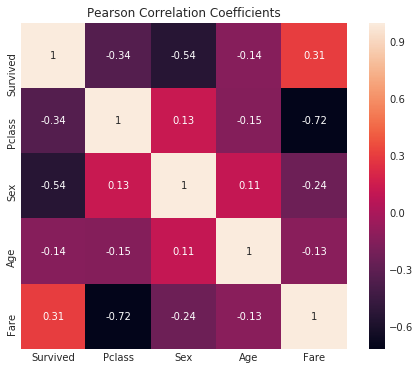

In [7]:

# As you can see, this newly processed data is much easier to work with.  
# Next we will visualize the data by making a heatmap. 
# The heatmap will illustrate the relationship between each numerical feature.  
def makeAHeatMap(input):
    """ 
    makes a heatmap of the dataframe illustrating Pearson Correlation Coefficients 
    """  
    plt.figure(figsize=[8,6])
    heatmap = sns.heatmap(input.corr(), vmax=1.0, square=True, annot=True)
    heatmap.set_title('Pearson Correlation Coefficients')
    return
makeAHeatMap(trainingData)


In [8]:

# As you can see, it looks like there is a pretty good correlation between surivival probability
# and ticket price, ticket class, and gender.  Let's explore this in more detail.

def pivotTheData(input):
    """ 
    takes a dataframe containing the Kaggle Titanic Data and describes the relationships between Sex, Fare, PClass, and Survived
    """      
    print('')
    print('Pivot Tables:')
    print('')
    print(input[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False))
    print('')
    print(input[["Fare", "Survived"]].groupby(['Fare'], as_index=False).mean().sort_values(by='Survived', ascending=False))
    print('')
    print(input[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False))
    print('')
    return
pivotTheData(trainingData)



Pivot Tables:

   Sex  Survived
0    0  0.742038
1    1  0.188908

   Fare  Survived
3     3  0.581197
2     2  0.443662
1     1  0.424581
0     0  0.199405

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363



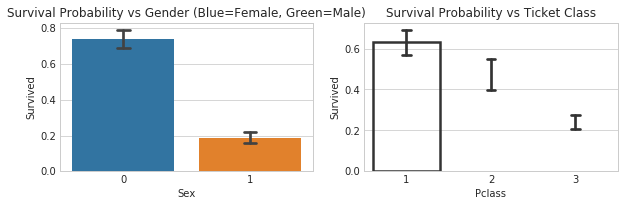

In [9]:


# Ticket price, ticket class, and gender are all correlated with survival probability.
# We will use graphs and plots to further illustrate these relationships.

def plotTheData(input):
    """ 
    takes a dataframe containing the Kaggle Titanic Data and illustrates the relationships between Sex, Fare, PClass, and Survived
    """  
    plt.figure(figsize=[10,6])
    plt.subplot(221)
    plotOne = sns.barplot('Sex', 'Survived', data=input, capsize=.1)
    plotOne.set_title('Survival Probability vs Gender (Blue=Female, Green=Male)')
    plt.subplot(222)
    plotTwo = sns.barplot('Pclass', 'Survived', data=input, capsize=.1, linewidth=2.5, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
    plotTwo.set_title('Survival Probability vs Ticket Class')
plotTheData(trainingData)


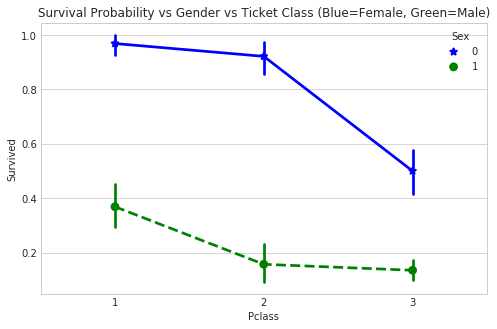

In [10]:

# Women have a higher probability of survival as compared to men.
# Similarly, passengers with First Class tickets have a higher probability of surivival than those without.
# Now let's look at both variables at the same time.


def plotTheDataAgain(input):
    """ 
    takes a dataframe containing the Kaggle Titanic Data and illustrates the relationships between Sex, Fare, PClass, and Survived all in one graph
    """    
    plt.figure(figsize=[8,5])
    plotThree = sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=input,
                  palette={1: "green", 0: "blue"},
                  markers=["*", "o"], linestyles=["-", "--"]);
    plotThree.set_title('Survival Probability vs Gender vs Ticket Class (Blue=Female, Green=Male)')
plotTheDataAgain(trainingData)



In [11]:

#	TABLE OF CONTENTS
    #a.	Part One: 75% Accuracy with a Minimal Dataset
        #i.	Load Data
        #ii.	Process Data
        #iii.	Describe Data 
        #iv.	Make Predictions 
        
        

# The passengers with the highest probability of survival were
# female passengers with First Class tickets.  
# Great!  This means that our classification algorithms should have something
# good to work with.  Next we will identify a suitable classification algorithm
# that we can use to predict whether or not a given passenger might survive.


# To do this, we will import some additional Python libraries that contain
# methods and algorithms that are helpful for machine learning applications.

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Furthermore, we will need to split up our training data, setting aside 20%
# of the training data for cross-validation testing, such that we can avoid
# potentially overfitting the data.
X_train = 0
X_test = 0
Y_train = 0
Y_test = 0
xValues = trainingData.drop(['Survived'], axis=1)
yValues = trainingData['Survived']
X_train, X_test, Y_train, Y_test = train_test_split(xValues, yValues, test_size=0.2)
# The train_test_split function is important for cross-validation
# Learn more about this important concept at the following links:
#http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
#http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation




Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

LR: 0.759477 (0.079717)
RF: 0.720588 (0.078720)
KNN: 0.719935 (0.085706)
SVM: 0.765033 (0.078858)
LSVM: 0.765033 (0.074842)
GNB: 0.743464 (0.099168)
DTC: 0.692157 (0.096045)
GBC: 0.748366 (0.076320)


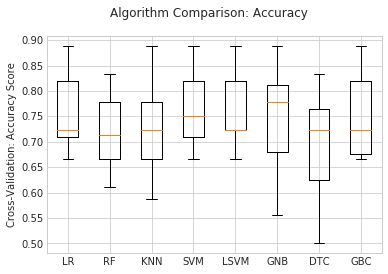


LR = LogisticRegression
RF = RandomForestClassifier
KNN = KNeighborsClassifier
SVM = Support Vector Machine SVC
LSVM = LinearSVC
GNB = GaussianNB
DTC = DecisionTreeClassifier
GBC = GradientBoostingClassifier



In [12]:

# Compare Performance of Classification Algorithms
def compareABunchOfDifferentModelsAccuracy(a,b,c,d):
    """
    compare performance of classifiers on X_train, X_test, Y_train, Y_test
    http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
    http://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score
    """    
    print('')
    print('Compare Multiple Classifiers:')
    print('')
    print('K-Fold Cross-Validation Accuracy:')
    print('')
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('SVM', SVC()))
    models.append(('LSVM', LinearSVC()))
    models.append(('GNB', GaussianNB()))
    models.append(('DTC', DecisionTreeClassifier()))
    models.append(('GBC', GradientBoostingClassifier()))
    #models.append(('LDA', LinearDiscriminantAnalysis()))       
    resultsAccuracy = []
    names = []
    for name, model in models:
        model.fit(a, b)
        kfold = model_selection.KFold(n_splits=10)
        accuracy_results = model_selection.cross_val_score(model, c, d, cv=kfold, scoring='accuracy')
        resultsAccuracy.append(accuracy_results)
        names.append(name)
        accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
        print(accuracyMessage)  
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison: Accuracy')
    ax = fig.add_subplot(111)
    plt.boxplot(resultsAccuracy)
    ax.set_xticklabels(names)
    ax.set_ylabel('Cross-Validation: Accuracy Score')
    plt.show()
    return
compareABunchOfDifferentModelsAccuracy(X_train, Y_train, X_test, Y_test)


def defineModels():
    """
    This function just defines each abbreviation used in the previous function (e.g. LR = Logistic Regression)
    """
    print('')
    print('LR = LogisticRegression')
    print('RF = RandomForestClassifier')
    print('KNN = KNeighborsClassifier')
    print('SVM = Support Vector Machine SVC')
    print('LSVM = LinearSVC')
    print('GNB = GaussianNB')
    print('DTC = DecisionTreeClassifier')
    print('GBC = GradientBoostingClassifier')
    #print('LDA = LinearDiscriminantAnalysis')
    print('')
    return
defineModels()




Compare Multiple Classifiers:

F1 Score:

LR: 0.743986 (0.087963)
RF: 0.734557 (0.085455)
KNN: 0.707587 (0.086529)
SVM: 0.752254 (0.086178)
LSVM: 0.748950 (0.083783)
GNB: 0.738324 (0.099179)
DTC: 0.678536 (0.089716)
GBC: 0.736149 (0.077589)


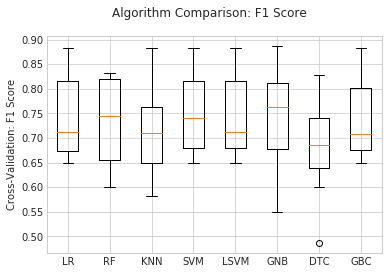


LR = LogisticRegression
RF = RandomForestClassifier
KNN = KNeighborsClassifier
SVM = Support Vector Machine SVC
LSVM = LinearSVC
GNB = GaussianNB
DTC = DecisionTreeClassifier
GBC = GradientBoostingClassifier



In [13]:


# It looks like all nine of these algorithms can do a decent job at this classification task.
# Here we are looking at the "Accuracy Score".  But there is another metric called the F1
# score that does an even better job of comparing model performance.  Let's try that now.
# Read about F1 scores at: 
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
# http://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics

def compareABunchOfDifferentModelsF1Score(a,b,c,d):
    """
    compare performance of classifiers on X_train, X_test, Y_train, Y_test
    http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
    http://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics
    """   
    print('')
    print('Compare Multiple Classifiers:')
    print('')
    print('F1 Score:')
    print('')
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('SVM', SVC()))
    models.append(('LSVM', LinearSVC()))
    models.append(('GNB', GaussianNB()))
    models.append(('DTC', DecisionTreeClassifier()))
    models.append(('GBC', GradientBoostingClassifier()))
    #models.append(('LDA', LinearDiscriminantAnalysis()))       
    resultsF1 = []
    names = []
    for name, model in models:
        model.fit(a, b)
        kfold = model_selection.KFold(n_splits=10)
        f1_results = model_selection.cross_val_score(model, c, d, cv=kfold, scoring='f1_macro')
        resultsF1.append(f1_results)
        names.append(name)
        f1Message = "%s: %f (%f)" % (name, f1_results.mean(), f1_results.std())
        print(f1Message)
    # boxplot algorithm comparison       
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison: F1 Score')
    ax = fig.add_subplot(111)
    plt.boxplot(resultsF1)
    ax.set_xticklabels(names)
    ax.set_ylabel('Cross-Validation: F1 Score')
    plt.show()
    return
compareABunchOfDifferentModelsF1Score(X_train, Y_train, X_test, Y_test)
defineModels()



<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

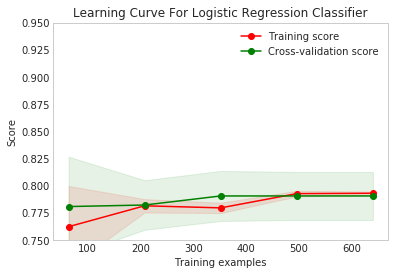

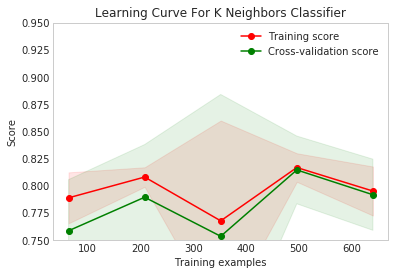

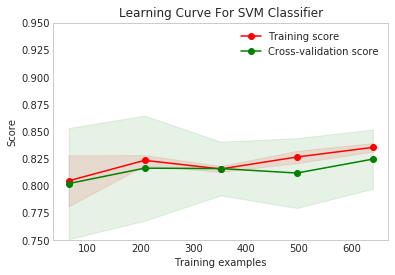

In [14]:

# Again, it looks like all nine algorithms do a pretty decent job.
# Let's look at three of them in more detail.
# Logistic Regression is my favorite algorithm, so let's look at that.
# I also like Support Vector Machines, so we will look at that as well.
# The KNN Classifier also had very good F1 scores so we will look at it too.

# The way that we are going to further compare these three algorithms
# is by looking at the effect of the sample size on the accuracy score
# for both the training dataset and the cross-validation dataset.
# These learning curves will help us to determine if a given classifier
# might be overfitting the training dataset.
# For more information about learning curves, read the following documentation: 
# http://scikit-learn.org/stable/modules/learning_curve.html


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Plots a learning curve. http://scikit-learn.org/stable/modules/learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
plot_learning_curve(LogisticRegression(), 'Learning Curve For Logistic Regression Classifier', X_train, Y_train, (0.75,0.95), 10)
plot_learning_curve(KNeighborsClassifier(), 'Learning Curve For K Neighbors Classifier', X_train, Y_train, (0.75,0.95), 10)
plot_learning_curve(SVC(), 'Learning Curve For SVM Classifier', X_train, Y_train, (0.75,0.95), 10)


In [15]:
# Great!  These learning curves were really informative.  
# We want a learning curve where the training score gets
# close to converging with the cross-validation score
# without any obvious overfitting.
# The SVM classifier looks pretty good in this example.


# Now we will try to optimize the parameters for the Logistic Regression, SVM, and KNN classifiers.


# To select parameters, we use the functino grid_searchCV
# To learn more about this function, see the following documentation:
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
#http://scikit-learn.org/stable/modules/grid_search.html#grid-search

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

def selectParametersForLR(a, b, c, d):
    """ Select Parameters for LR using SKlearn GridSearchCV function
    http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    http://scikit-learn.org/stable/modules/grid_search.html#grid-search"""
    model = LogisticRegression()
    parameters = {'C': [0.01, 0.1, 0.5, 1.0, 5.0, 10, 25, 50, 100],
                  'solver' : ['newton-cg', 'lbfgs', 'liblinear']}
    accuracy_scorer = make_scorer(accuracy_score)
    grid_obj = GridSearchCV(model, parameters, scoring=accuracy_scorer, error_score = 0.01)
    grid_obj = grid_obj.fit(a, b)
    model = grid_obj.best_estimator_
    model.fit(a, b)
    print('Selected Parameters for LR:')
    print('')
    print(model)
    print('')
#    predictions = model.predict(c)
#    print(accuracy_score(d, predictions))
#    print('Logistic Regression - Training set accuracy: %s' % accuracy_score(d, predictions))
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(model, c, d, cv=kfold, scoring='accuracy')
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('Logistic Regression - Training set accuracy: %s (%s)' % (mean, stdev))
    print('')
    return

selectParametersForLR(X_train, Y_train, X_test, Y_test)

# Optimize Parameters for SVM

def selectParametersForSVM(a, b, c, d):
    """ Select Parameters for SVM using SKlearn GridSearchCV function
    http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    http://scikit-learn.org/stable/modules/grid_search.html#grid-search"""
    model = SVC()
    parameters = {'C': [0.01, 0.1, 0.5, 1.0, 5.0, 10, 25, 50, 100],
                  'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
    accuracy_scorer = make_scorer(accuracy_score)
    grid_obj = GridSearchCV(model, parameters, scoring=accuracy_scorer)
    grid_obj = grid_obj.fit(a, b)
    model = grid_obj.best_estimator_
    model.fit(a, b)
    print('Selected Parameters for SVM:')
    print('')
    print(model)
    print('')
#    predictions = model.predict(c)
#    print(accuracy_score(d, predictions))
#    print('Logistic Regression - Training set accuracy: %s' % accuracy_score(d, predictions))
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(model, c, d, cv=kfold, scoring='accuracy')
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('Support Vector Machine - Training set accuracy: %s (%s)' % (mean, stdev))
    print('')
    return
selectParametersForSVM(X_train, Y_train, X_test, Y_test)


# Optimize Parameters for KNN

def selectParametersForKNN(a, b, c, d):
    """ Select Parameters for KNN using SKlearn GridSearchCV function
    http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    http://scikit-learn.org/stable/modules/grid_search.html#grid-search"""
    model = KNeighborsClassifier()
    parameters = {'n_neighbors': [5, 10, 25, 50],
                  'algorithm': ['ball_tree', 'kd_tree'],
                  'leaf_size': [5, 10, 25, 50]}
    accuracy_scorer = make_scorer(accuracy_score)
    grid_obj = GridSearchCV(model, parameters, scoring=accuracy_scorer)
    grid_obj = grid_obj.fit(a, b)
    model = grid_obj.best_estimator_
    model.fit(a, b)
    print('Selected Parameters for KNN:')
    print('')
    print(model)
    print('')
#    predictions = model.predict(c)
#    print(accuracy_score(d, predictions))
#    print('Logistic Regression - Training set accuracy: %s' % accuracy_score(d, predictions))
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(model, c, d, cv=kfold, scoring='accuracy')
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('K-Nearest Neighbors Classifier - Training set accuracy: %s (%s)' % (mean, stdev))
    print('')
    return
selectParametersForKNN(X_train, Y_train,  X_test, Y_test)


Selected Parameters for LR:

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

Logistic Regression - Training set accuracy: 0.765032679739 (0.089836000968)

Selected Parameters for SVM:

SVC(C=25, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Support Vector Machine - Training set accuracy: 0.770588235294 (0.0851782199093)

Selected Parameters for KNN:

KNeighborsClassifier(algorithm='ball_tree', leaf_size=25, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

K-Nearest Neighbors Classifier - Training set accuracy: 0.719934640523 (0.0857063137453)


In [16]:

# That is pretty good for such a simple approach!  
# Now we cam make our predictions about survival using the test dataset.


#	TABLE OF CONTENTS
    #a.	Part One: 75% Accuracy with a Minimal Dataset
        #i.	Load Data
        #ii.	Process Data
        #iii.	Describe Data 
        #iv.	Make Predictions 
        #v.	Submit Predictions 

# To submit a prediction to kaggle.com, do the following:

# Submission with LinearSVC

# Load testing Data (to extract PassengerID Only)
#testingData2 = pd.read_csv('test.csv')
testingData2 = pd.read_csv('../input/test.csv')
# Define Model, Predict, Submitmodel = votingC
model = LinearSVC(C=0.0001, class_weight=None, dual=True, fit_intercept=True,intercept_scaling=1, loss='squared_hinge', max_iter=1000,multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,verbose=0)
model.fit(X_train, Y_train)
prediction = model.predict(testingData)
prediction = prediction.astype(int)
submission = pd.DataFrame({
    "PassengerId": testingData2["PassengerId"],
    "Survived": prediction})
submission.to_csv('_new_submission_simpleModel_SVM.csv', index=False)
# to finish the submission process, upload the file '_new_submission_.csv' to Kaggle



In [17]:

#############################
# Part Two: 80% Accuracy with an Expanded Dataset
#############################



# In Part One we achieved >75% accuracy by using a minimal dataset.
# In Part Two we will achieve >80% accuracy by using an expanded dataset.

#	TABLE OF CONTENTS
    #b.	Part Two: 80% Accuracy with an Expanded Dataset
        #i.	Load Data
        #ii.	Process Data


In [18]:

# At this point it is easier to just start over from scratch.
# Load the data
#trainingData = pd.read_csv('train.csv')
#testingData = pd.read_csv('test.csv')
trainingData = pd.read_csv('../input/train.csv')
testingData = pd.read_csv('../input/test.csv')
# Combine the data so that we can do feature engineering to both the training and testing datasets
trainingData['is_test'] = 0 # this will be helpful when we split up the data again later
testingData['is_test'] = 1 
fullData = pd.concat((trainingData, testingData), axis=0)
# Drop irrelevant data
fullData = fullData.drop(['PassengerId'], axis=1)
# Replace missing values with median values
def replaceMissingWithMedian(dataframe):
    """ Replace missing values wiht median values"""
    dataframe['Fare'].fillna(fullData['Fare'].dropna().median(), inplace=True)   
    dataframe['Age'].fillna(fullData['Age'].dropna().median(), inplace=True)
    dataframe['Cabin'].fillna('Z', inplace=True)
    dataframe['Embarked'].fillna('S', inplace=True)
    dataframe = dataframe.fillna(-0.5)
replaceMissingWithMedian(fullData)
# Replace age numbers with age categories
def replaceAgeNumbersWithCategories(dataframe):
    """Replace age numbers with age categories"""
    dataframe['Age'] = dataframe.Age.fillna(-0.5)
    bins = (-0.01, 4, 12, 18, 60, 150)
    categories = pd.cut(dataframe.Age, bins, labels=False)
    dataframe.Age = categories
replaceAgeNumbersWithCategories(fullData)
# Replace fare numbers with fare categories
def replaceFareNumbersWithCategories(dataframe):
    """Replace fare numbers with fare categories"""
    dataframe['Fare'] = dataframe.Fare.fillna(-0.5)
    bins = (-0.01, 10, 20, 30, 1000)
    categories = pd.cut(dataframe.Fare, bins, labels=False)
    dataframe.Fare = categories
replaceFareNumbersWithCategories(fullData)   


In [19]:

#	TABLE OF CONTENTS
    #b.	Part Two: 80% Accuracy with an Expanded Dataset
        #i.	Load Data
        #ii.	Process Data
        #iii.	Engineer Data

# Here we are engineering new features that were not included in our original strategy
# Make feature "Name Title"
def makeFeatureNameTitle(dataframe):
    """ make feature Name Title from out feature Name"""
    name = dataframe['Name']
    full_name = name.str.split(', ', n=0, expand=True)
    last_name = full_name[0]
    titles = full_name[1].str.split('.', n=0, expand=True)
    titles = titles[0]
    dataframe['Name'] = titles
    newTitles = titles.replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataframe['Name'] = newTitles
makeFeatureNameTitle(fullData)
# Extract Cabin Letter from Cabin Name and Delete all other info
def extractCabinLetterDeleteOther(dataframe):
    """ Extract Cabin Letter from Cabin Name and Delete all other info"""
    dataframe['Cabin'] = dataframe['Cabin'].str[0]    
    # Extract Family Size from SibSp + Parch and then make new family size groups
    dataframe['FamilySize'] = dataframe['SibSp'] + dataframe['Parch'] + 1
    dataframe['FamilySize'] = dataframe.FamilySize.fillna(-0.5)
    bins = (-1, 1, 2, 4, 6, 1000)
    categories = pd.cut(dataframe.FamilySize, bins, labels=False)
    dataframe['FamilySize'] = categories
extractCabinLetterDeleteOther(fullData)
# Extract whether or not the Ticket Number has a Prefix (possibly indicating special privileges)
def extractTicketPrefix(dataframe):
    """Extract whether or not the Ticket Number has a Prefix (possibly indicating special privileges)"""
    Ticket = []
    for i in list(dataframe.Ticket):
        if not i.isdigit() :
            Ticket.append("1")
        else:
            Ticket.append("0")     
    dataframe["Ticket"] = Ticket
extractTicketPrefix(fullData)

# Replace categorical with numerical
# implements the pd.get_dummies function to convert categorical columns to multiple binary columns
# Learn more about get_dummies and the advantages of binary data representation at the following link:
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html
fullData = pd.get_dummies(fullData, columns=['Pclass', 'Sex', 'Embarked', 'Age', 'Fare', 'Cabin', 'Name', 'FamilySize', 'Ticket'])
# Now we split the combined data back into training and testing data since we have finished with the feature engineering
trainingData = fullData[fullData['is_test'] == 0]
testingData = fullData[fullData['is_test'] == 1]
# Describe the data
describeDataAgain(trainingData)

# Furthermore, we will need to split up our training data, setting aside 20%
# of the training data for cross-validation testing, such that we can avoid
# potentially overfitting the data.
X = trainingData.drop(['Survived', 'is_test'], axis=1)
y = trainingData['Survived']
#X = trainingData.iloc[0:5000,1:] 
#y = trainingData.iloc[0:5000,:1] 
#y = pd.get_dummies(y)
xValues = X
yValues = y.values.ravel()
#yValues = y
# Here comes the important part
X_train, X_test, Y_train, Y_test = train_test_split(xValues, yValues, test_size=0.2)
# The train_test_split function is important for cross-validation
# Learn more about this important concept at the following links:
#http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
#http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation


New summary of data after making changes:

Column Values:

['Parch' 'SibSp' 'Survived' 'is_test' 'Pclass_1' 'Pclass_2' 'Pclass_3'
 'Sex_female' 'Sex_male' 'Embarked_C' 'Embarked_Q' 'Embarked_S' 'Age_0'
 'Age_1' 'Age_2' 'Age_3' 'Age_4' 'Fare_0' 'Fare_1' 'Fare_2' 'Fare_3'
 'Cabin_A' 'Cabin_B' 'Cabin_C' 'Cabin_D' 'Cabin_E' 'Cabin_F' 'Cabin_G'
 'Cabin_T' 'Cabin_Z' 'Name_Master' 'Name_Miss' 'Name_Mlle' 'Name_Mme'
 'Name_Mr' 'Name_Mrs' 'Name_Ms' 'Name_Rare' 'FamilySize_0' 'FamilySize_1'
 'FamilySize_2' 'FamilySize_3' 'FamilySize_4' 'Ticket_0' 'Ticket_1']

First Few Values:

   Parch  SibSp  Survived  is_test  Pclass_1  Pclass_2  Pclass_3  Sex_female  \
0      0      1       0.0        0         0         0         1           0   
1      0      1       1.0        0         1         0         0           1   
2      0      0       1.0        0         0         0         1           1   
3      0      1       1.0        0         1         0         0           1   
4      0      0       0.0


Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

LR: 0.810784 (0.074785)
RF: 0.777451 (0.101911)
KNN: 0.800000 (0.111665)
SVM: 0.799673 (0.086240)
LSVM: 0.805229 (0.074967)
GNB: 0.693464 (0.095655)
DTC: 0.749346 (0.119055)
GBC: 0.771569 (0.090298)


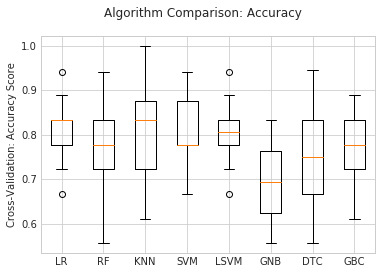


LR = LogisticRegression
RF = RandomForestClassifier
KNN = KNeighborsClassifier
SVM = Support Vector Machine SVC
LSVM = LinearSVC
GNB = GaussianNB
DTC = DecisionTreeClassifier
GBC = GradientBoostingClassifier



In [20]:
# Train and cross-validate multiple classification algorithms and compare the result
# Compare Classification Algorithms
compareABunchOfDifferentModelsAccuracy(X_train, Y_train, X_test, Y_test)
defineModels()

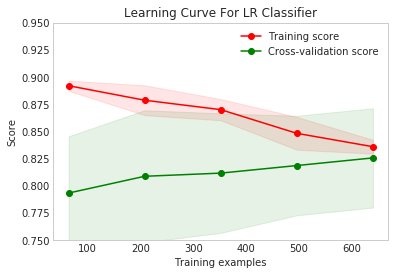

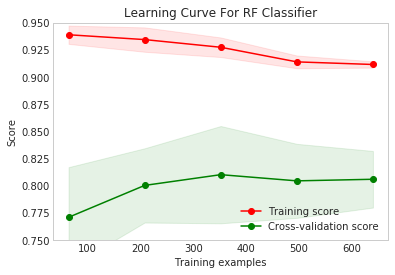

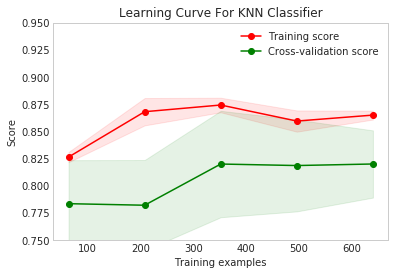

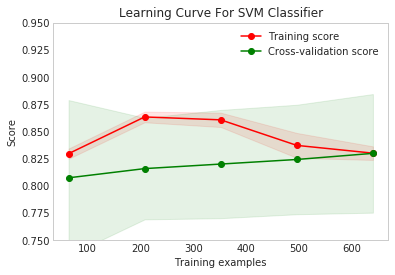

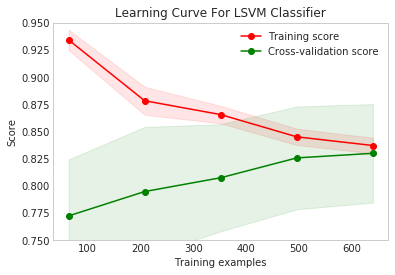

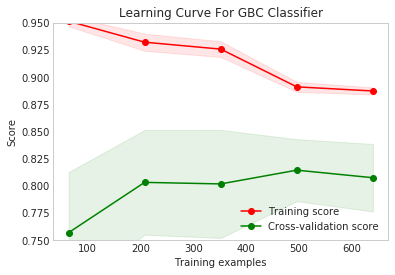

In [21]:

# Now let's plot a bunch of learning curves to see if we can find a method that does not overfit the data
# http://scikit-learn.org/stable/modules/learning_curve.html
def plotLotsOfLearningCurves(a,b):
    """Now let's plot a bunch of learning curves
    # http://scikit-learn.org/stable/modules/learning_curve.html
    """
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('SVM', SVC()))
    models.append(('LSVM', LinearSVC()))
    #models.append(('GNB', GaussianNB()))
    #models.append(('DTC', DecisionTreeClassifier()))
    models.append(('GBC', GradientBoostingClassifier()))
    #models.append(('LDA', LinearDiscriminantAnalysis()))
    
    for name, model in models:
        plot_learning_curve(model, 'Learning Curve For %s Classifier'% (name), a,b, (0.75,0.95), 10)
plotLotsOfLearningCurves(X_train, Y_train)


Optimal number of features : 9


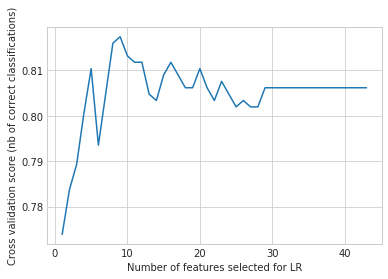

Optimal number of features : 38


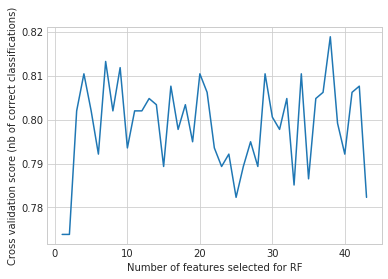

Optimal number of features : 29


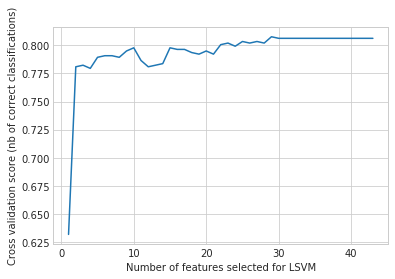

Optimal number of features : 5


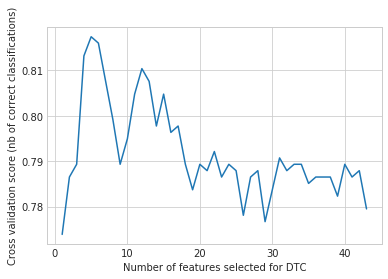

Optimal number of features : 7


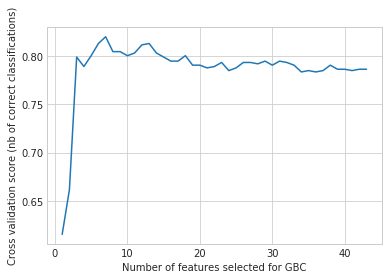

In [22]:
# Great!  It looks like our best choice to avoid overfitting is LinearSVC, or maybe Logistic Regression.


#	TABLE OF CONTENTS 
    #b.	Part Two: 80% Accuracy with an Expanded Dataset
        #i.	Load Data
        #ii.	Process Data
        #iii.	Engineer Data
        #iv.  Select Features 

# Next I will do some feature selection

# How many features should I eliminate?

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

def determineOptimalFeatureNumber(a,b):
    """
    #http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
    """
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('RF', RandomForestClassifier()))
    #models.append(('KNN', KNeighborsClassifier()))
    #models.append(('SVM', SVC()))
    models.append(('LSVM', LinearSVC()))
    #models.append(('GNB', GaussianNB()))
    models.append(('DTC', DecisionTreeClassifier()))
    models.append(('GBC', GradientBoostingClassifier()))
    #models.append(('LDA', LinearDiscriminantAnalysis()))
    
    for name, model in models:
        # Create the RFE object and compute a cross-validated score.
        currentModel = model
        # The "accuracy" scoring is proportional to the number of correct
        # classifications
        rfecv = RFECV(estimator=currentModel, step=1, cv=StratifiedKFold(2), scoring='accuracy')
        rfecv.fit(a,b)
        print("Optimal number of features : %d" % rfecv.n_features_)
        # Plot number of features VS. cross-validation scores
        plt.figure()
        plt.xlabel("Number of features selected for %s" % (name))
        plt.ylabel("Cross validation score (nb of correct classifications)")
        plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
        plt.show()

determineOptimalFeatureNumber(X_train, Y_train)



In [23]:
# Currently there are almost 45 features but most algorithms prefer somewhere between 5 and 20 features.
# LinearSVM likes somewhere between 5 and 10.


# Now we will eliminate all but the most helpful features
# We will do this by fitting a LinearSVC and then identifying the best coefficients
#from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import make_scorer, accuracy_score
  
#Run LinearSVC
def runLinearSVC(a,b,c,d):
    """Run LinearSVC w/ Kfold CV"""
    model = LinearSVC()
    model.fit(a,b)
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(model, c,d, cv=kfold, scoring='accuracy')
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('LinearSVC - Training set accuracy: %s (%s)' % (mean, stdev))
    print('')
runLinearSVC(X_train, Y_train, X_test, Y_test)


LinearSVC - Training set accuracy: 0.80522875817 (0.0749670638376)



In [24]:


# Identify best feature coefficients (coef_) and/or feature importance (feature_importances_)
model = LinearSVC()
model.fit(X_train,Y_train) # Needed to initialize coef_
columns = X_train.columns
coefficients = model.coef_.reshape(X_train.columns.shape[0], 1)
absCoefficients = abs(coefficients)
fullList = pd.concat((pd.DataFrame(columns, columns = ['Variable']), pd.DataFrame(absCoefficients, columns = ['absCoefficient'])), axis = 1).sort_values(by='absCoefficient', ascending = False)
print('LinearSVC - Feature Importance:')
print('')
print(fullList)
print('')
# Remove all but the most helpful features
topTwenty = fullList[:15]
featureList = topTwenty.values
featureList = pd.DataFrame(featureList)
featuresOnly = featureList[0]
featuresOnly = list(featuresOnly)
featuresOnly += ['is_test', 'Survived']
fullData = fullData[featuresOnly]
trainingData = fullData[fullData['is_test'] == 0]
testingData = fullData[fullData['is_test'] == 1]
#g = sns.heatmap(trainingData[featuresOnly].corr(),cmap="BrBG",annot=False)

# Let's see if we improved our accuracy scores
X = trainingData.drop(['Survived', 'is_test'], axis=1)
y = trainingData['Survived']
xValues = X
yValues = y.values.ravel()
X_train, X_test, Y_train, Y_test = train_test_split(xValues, yValues, test_size=0.2)
print('')
print('Dataset reduced to the following columns:')
print('')
print(X_train.columns)


LinearSVC - Feature Importance:

        Variable  absCoefficient
28   Name_Master    9.244156e-01
23       Cabin_E    6.239762e-01
5     Sex_female    5.864809e-01
26       Cabin_T    4.775552e-01
6       Sex_male    4.282446e-01
35     Name_Rare    3.715171e-01
38  FamilySize_2    3.270336e-01
22       Cabin_D    3.243304e-01
39  FamilySize_3    3.123098e-01
32       Name_Mr    3.114816e-01
10         Age_0    2.755121e-01
34       Name_Ms    2.263774e-01
1          SibSp    2.021889e-01
14         Age_4    1.989148e-01
2       Pclass_1    1.801164e-01
25       Cabin_G    1.758930e-01
27       Cabin_Z    1.750276e-01
29     Name_Miss    1.726287e-01
4       Pclass_3    1.670442e-01
0          Parch    1.654405e-01
3       Pclass_2    1.451641e-01
40  FamilySize_4    1.434301e-01
18        Fare_3    1.416633e-01
33      Name_Mrs    1.369292e-01
8     Embarked_Q    1.324846e-01
20       Cabin_B    1.236335e-01
42      Ticket_1    1.218257e-01
7     Embarked_C    7.260332e-02
37  Family

In [25]:

## See if the score of the Linear SVC improved after narrowing down the number of features
# Run LSVC
print('')
print('After feature selection:')
print('')
runLinearSVC(X_train, Y_train, X_test, Y_test)



After feature selection:

LinearSVC - Training set accuracy: 0.770588235294 (0.0735083484718)



After Feature Selection


Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

LR: 0.799346 (0.060949)
RF: 0.776797 (0.069556)
KNN: 0.782353 (0.062387)
SVM: 0.804248 (0.057695)
LSVM: 0.770588 (0.073508)
GNB: 0.760131 (0.069543)
DTC: 0.771242 (0.079621)
GBC: 0.776144 (0.071721)


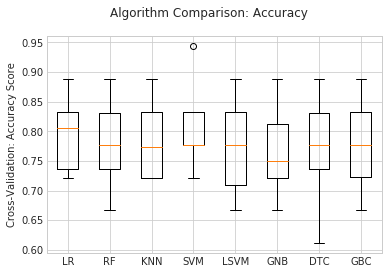


LR = LogisticRegression
RF = RandomForestClassifier
KNN = KNeighborsClassifier
SVM = Support Vector Machine SVC
LSVM = LinearSVC
GNB = GaussianNB
DTC = DecisionTreeClassifier
GBC = GradientBoostingClassifier



In [26]:

# And now let's see how the other classification algorithms like the reduction in features
print('After Feature Selection')
print('')
compareABunchOfDifferentModelsAccuracy(X_train, Y_train, X_test, Y_test)
defineModels()

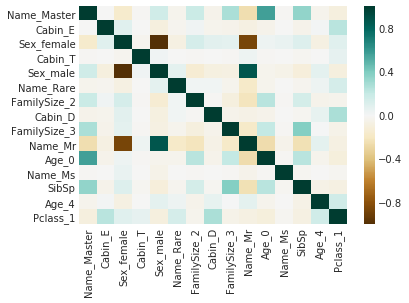

In [27]:

# We want to use some linear classifiers, so we need to make sure that none of our features are too hgihly correlated
# First let's look at a heatmap of correlations between each feature

g = sns.heatmap(X_train.corr(),cmap="BrBG",annot=False)


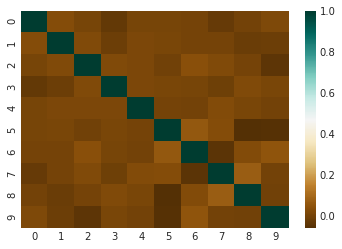

In [28]:

# Some of these features are highly correlated 
# This can cause problems for some algorithms such as linear classifiers
# As such, we will now transform our features to make them no longer be correlated
# this is done by applying a transformation and dimensionality reduction to the data
# this process is called principal component analysis (PCA)
# Fore more info, see the following documentaion:
# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
# http://scikit-learn.org/stable/modules/decomposition.html#pca
#

# Now let's do a PCA to help with multicollinearity between the remaining features
from sklearn.decomposition import PCA
# Minimum percentage of variance we want to be described by the resulting transformed components
variance_pct = .99
# Create PCA object
pca = PCA(n_components=variance_pct)
# Transform the initial features
X_transformed = pca.fit_transform(X,y)
#X_transformedTest = pca.fit_transform(xValuesTest,y)
#testingData = testingData[X_transformedTest]
# Create a data frame from the PCA'd data
pcaDataFrame = pd.DataFrame(X_transformed) 
#print(pcaDataFrame.shape[1], " components describe ", str(variance_pct)[1:], "% of the variance")
# Redefine X_train, X_test, Y_train, Y_test
xValues = pcaDataFrame
yValues = y.values.ravel()
#yValues = y
# Here comes the important part
X_train, X_test, Y_train, Y_test = train_test_split(xValues, yValues, test_size=0.2)
# Now do it to the test data as well
testingData = testingData.drop(['Survived', 'is_test'], axis=1)
testingData = pca.fit_transform(testingData)
testingData = pd.DataFrame(testingData) 

# Now we have new features (we transformed them) with new names
# There are fewer numbers of features now (dimensionality reduction)
# The features are no longer correlated, as illustrated below:

g = sns.heatmap(X_train.corr(),cmap="BrBG",annot=False)

# Alternatively we could have done this:
## First We will eliminate anything with a correlation score greater than .5
#def correlation(dataset, threshold):
#    col_corr = set() # Set of all the names of deleted columns
#    corr_matrix = dataset.corr()
#    for i in range(len(corr_matrix.columns)):
#        for j in range(i):
#            if corr_matrix.iloc[i, j] >= threshold:
#                colname = corr_matrix.columns[i] # getting the name of column
#                col_corr.add(colname)
#                if colname in dataset.columns:
#                    del dataset[colname] # deleting the column from the dataset
#    print('')
#    print('Dataset reduced to the following columns:')
#    print('')
#    print(dataset.columns)
#
#correlation(X_train, 0.5)
#correlation(X_test, 0.5)


In [29]:

# Our newly transformed featuers are no longer correlated.

#	TABLE OF CONTENTS 
    #b.	Part Two: 80% Accuracy with an Expanded Dataset
        #i.	Load Data
        #ii.	Process Data
        #iii.	Engineer Data
        #iv.  Select Features 
        #v.	Make Predictions 


# See if the score of the LinearSVC improved after the Feature Selection + PCA

# Run LSVC
print('')
print('After feature selection + PCA:')
print('')
runLinearSVC(X_train, Y_train, X_test, Y_test)



After feature selection + PCA:

LinearSVC - Training set accuracy: 0.872222222222 (0.0787635937709)



After Feature Selection + PCA


Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

LR: 0.855556 (0.075359)
RF: 0.837582 (0.059492)
KNN: 0.861111 (0.071362)
SVM: 0.866667 (0.079349)
LSVM: 0.872222 (0.078764)
GNB: 0.781699 (0.085391)
DTC: 0.826471 (0.064246)
GBC: 0.827124 (0.071694)


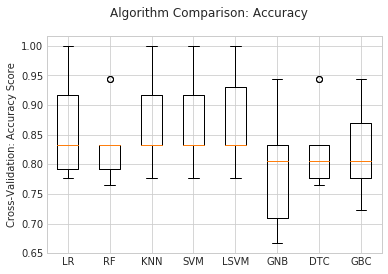


LR = LogisticRegression
RF = RandomForestClassifier
KNN = KNeighborsClassifier
SVM = Support Vector Machine SVC
LSVM = LinearSVC
GNB = GaussianNB
DTC = DecisionTreeClassifier
GBC = GradientBoostingClassifier



In [30]:

# Run classifiers after PCA
print('After Feature Selection + PCA')
print('')
compareABunchOfDifferentModelsAccuracy(X_train, Y_train, X_test, Y_test)
defineModels()


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

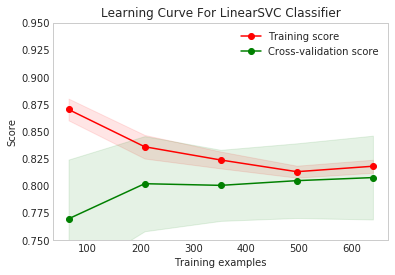

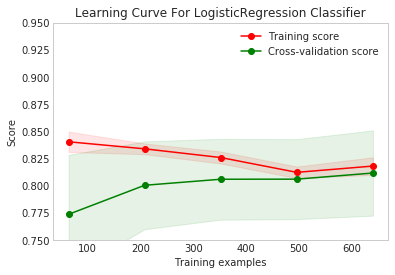

In [31]:
# Plot learning curve

plot_learning_curve(LinearSVC(), 'Learning Curve For %s Classifier'% ('LinearSVC'), X_train, Y_train, (0.75,0.95), 10)
plot_learning_curve(LogisticRegression(), 'Learning Curve For %s Classifier'% ('LogisticRegression'), X_train, Y_train, (0.75,0.95), 10)

In [32]:
# Those learning curves look great.

# Optimize Parameters for LSVC

# To select parameters, we use the functino grid_searchCV
# To learn more about this function, see the following documentation:
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
#http://scikit-learn.org/stable/modules/grid_search.html#grid-search

# Optimize Parameters for LSVM

def selectParametersForLSVM(a, b, c, d):
    """http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    http://scikit-learn.org/stable/modules/grid_search.html#grid-search"""
    model = LinearSVC()
    parameters = {'C': [0.00001, 0.001, .01, 0.1, 0.5, 1.0, 5.0, 10, 25, 50, 100, 1000]}
    accuracy_scorer = make_scorer(accuracy_score)
    grid_obj = GridSearchCV(model, parameters, scoring=accuracy_scorer)
    grid_obj = grid_obj.fit(a, b)
    model = grid_obj.best_estimator_
    model.fit(a, b)
    print('Selected Parameters for LSVM:')
    print('')
    print(model)
    print('')
#    predictions = model.predict(c)
#    print(accuracy_score(d, predictions))
#    print('Logistic Regression - Training set accuracy: %s' % accuracy_score(d, predictions))
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(model, c, d, cv=kfold, scoring='accuracy')
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('Linear Support Vector Machine - Training set accuracy: %s (%s)' % (mean, stdev))
    print('')
    return
selectParametersForLSVM(X_train, Y_train, X_test, Y_test)
runLinearSVC(X_train, Y_train, X_test, Y_test)


Selected Parameters for LSVM:

LinearSVC(C=50, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Linear Support Vector Machine - Training set accuracy: 0.866666666667 (0.0666666666667)

LinearSVC - Training set accuracy: 0.872222222222 (0.0787635937709)



In [33]:

# Let's also try running a few Neural Networks

# First we will use the Multi-layer Perceptron NN model from Sklearn
from sklearn.neural_network import MLPClassifier as MLPC
def runMLPC(a,b,c,d):
    classifier = MLPC(activation='relu', max_iter=1000)
    classifier.fit(a, b)
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(classifier, c, d, cv=kfold, scoring='accuracy')
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('SKlearn Multi-layer Perceptron NN - Training set accuracy: %s (%s)' % (mean, stdev))
    print('')
runMLPC(X_train, Y_train,  X_test, Y_test)


SKlearn Multi-layer Perceptron NN - Training set accuracy: 0.866013071895 (0.0664773680516)



In [34]:

# Now let's see if we can improve the score with parameter optimization
# Optimize Parameters for MLP-NN

def selectParametersForMLPC(a, b, c, d):
    """http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    http://scikit-learn.org/stable/modules/grid_search.html#grid-search"""
    model = MLPC()
    parameters = {'verbose': [False],
                  'activation': ['logistic', 'relu'],
                  'max_iter': [1000, 2000], 'learning_rate': ['constant', 'adaptive']}
    accuracy_scorer = make_scorer(accuracy_score)
    grid_obj = GridSearchCV(model, parameters, scoring=accuracy_scorer)
    grid_obj = grid_obj.fit(a, b)
    model = grid_obj.best_estimator_
    model.fit(a, b)
    print('Selected Parameters for Multi-Layer Perceptron NN:')
    print('')
    print(model)
    print('')
#    predictions = model.predict(c)
#    print(accuracy_score(d, predictions))
#    print('Logistic Regression - Training set accuracy: %s' % accuracy_score(d, predictions))
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(model, c, d, cv=kfold, scoring='accuracy')
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('SKlearn Multi-Layer Perceptron - Training set accuracy: %s (%s)' % (mean, stdev))
    print('')
    return

selectParametersForMLPC(X_train, Y_train,  X_test, Y_test)


Selected Parameters for Multi-Layer Perceptron NN:

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

SKlearn Multi-Layer Perceptron - Training set accuracy: 0.866013071895 (0.0664773680516)



In [35]:

# Now let's try some other neural networks
from __future__ import print_function
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# We will build some custom neural networks using keras
# https://keras.io/models/sequential/

def runTwoKerasClassifiers(a,b,c,d):
    """ Build and run Two different NNs using Keras"""
    global kerasModelOne, kerasModelTwo # eventually I should get rid of these global variables and use classes instead.  in this case i need these variables for the submission function.
    # Let's start out with a simple network consisting of only two fully connected layers.
    Adagrad(lr=0.00001, epsilon=1e-08, decay=0.0)
    model = Sequential()
    model.add(Dense(input_dim=np.array(a).shape[1], units=128, kernel_initializer='normal', bias_initializer='zeros'))
    model.add(Activation('relu'))
    model.add(Dense(units=1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
    model.fit(np.array(a), np.array(b), epochs=10, verbose=2, validation_split=0.2)
    score = model.evaluate(np.array(c),np.array(d), verbose=0)
    print('')
    print('Loss, Accuracy:')
    print(score)
    kerasModelOne = model  
    # Now let's make a new network, a deep network, that has 15 additional fully connected layers and also 15 dropout functions
    #RMSprop(lr=0.00001, rho=0.9, epsilon=1e-08, decay=0.0)
    Adagrad(lr=0.00001, epsilon=1e-08, decay=0.0)
    #Adadelta(lr=0.00001, rho=0.95, epsilon=1e-08, decay=0.0)
    model = Sequential()
    model.add(Dense(input_dim=np.array(a).shape[1], units=128,
                     kernel_initializer='normal', bias_initializer='zeros'))
    model.add(Activation('relu'))
    for i in range(0, 15):
        model.add(Dense(units=128, kernel_initializer='normal',
                         bias_initializer='zeros'))
        model.add(Activation('relu'))
        model.add(Dropout(.40))
    model.add(Dense(units=1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
    print('Running Deep Neural Network: Expect Delays')
    model.fit(np.array(a), np.array(b), epochs=10, verbose=2, validation_split=0.2)
    score = model.evaluate(np.array(c),np.array(d), verbose=0)
    print('')
    print('Loss, Accuracy:')
    print(score)
    kerasModelTwo = model
    return kerasModelOne, kerasModelTwo
runTwoKerasClassifiers(X_train,Y_train,X_test,Y_test)


Using TensorFlow backend.
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Train on 569 samples, validate on 143 samples
Epoch 1/10
0s - loss: 0.5791 - acc: 0.7715 - val_loss: 0.4858 - val_acc: 0.8252
Epoch 2/10
0s - loss: 0.4787 - acc: 0.8067 - val_loss: 0.4339 - val_acc: 0.8322
Epoch 3/10
0s - loss: 0.4518 - acc: 0.8049 - val_loss: 0.4206 - val_acc: 0.8322
Epoch 4/10
0s - loss: 0.4419 - acc: 0.8102 - val_loss: 0.4164 - val_acc: 0.8322
Epoch 5/10
0s - loss: 0.4367 - acc: 0.8084 - val_loss: 0.4154 - val_acc: 0.8322
Epoch 6/10
0s - loss: 0.4338 - acc: 0.8102 - val_loss: 0.4124 - val_acc: 0.8462
Epoch 7/10
0s - loss: 0.4316 - acc: 0.8084 - val_loss: 0.4119 - val_acc: 0.8462
Epoch 8/10
0s - loss: 0.4302 - acc: 0.8084 - val_loss: 0.4111 - val_acc: 0.8462
Epoch 9/10
0s - loss: 0.4282 - acc: 0.8084 - val_loss: 0.4095 - val_acc: 0.8462
Epoch 10/10
0s - loss: 0.4270 - acc: 0.8137 - val_loss: 0.4099 - val_acc: 0.8462

Loss, Accuracy:
[0.37600650500984834, 0.87150837822333393]
Running Deep Neural Network: Expect Delays
Train on 569 samples, validate on 143 samples
Epoc

(<keras.models.Sequential at 0x7f392fc59588>,
 <keras.models.Sequential at 0x7f38e660bf98>)

In [36]:

# To try to get an even higher score, I will now combine the MLPC and LSVC/SVM methods by using a new method called ensemble voting.
# It only works with Sklearn classifiers so that is why I did not include Keras.
# This new method should help to avoid overfitting by taking into consideration both MLPC and SVMs predictions.
# To learn more about the VotingClassifier function, see the following documentation:
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
# http://scikit-learn.org/stable/modules/ensemble.html#voting-classifier


from sklearn.ensemble import VotingClassifier

def runVotingClassifier(a,b,c,d):
    """http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
    http://scikit-learn.org/stable/modules/ensemble.html#voting-classifier"""
    global votingC, mean, stdev # eventually I should get rid of these global variables and use classes instead.  in this case i need these variables for the submission function.
    votingC = VotingClassifier(estimators=[('LSVM', LinearSVC(C=0.0001, class_weight=None, dual=True, fit_intercept=True,
         intercept_scaling=1, loss='squared_hinge', max_iter=1000,
         multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
         verbose=0)), ('MLPC', MLPC(activation='logistic', alpha=0.0001, batch_size='auto',
           beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
           hidden_layer_sizes=(100,), learning_rate='constant',
           learning_rate_init=0.001, max_iter=2000, momentum=0.9,
           nesterovs_momentum=True, power_t=0.5, random_state=None,
           shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
           verbose=False, warm_start=False))], voting='hard')  
    votingC = votingC.fit(a,b)   
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(votingC, c,d, cv=kfold, scoring='accuracy')
    meanC = accuracy.mean() 
    stdevC = accuracy.std()
    print('Ensemble Voting Method - Training set accuracy: %s (%s)' % (meanC, stdevC))
    print('')
    return votingC, meanC, stdevC
runVotingClassifier(X_train,Y_train,X_test,Y_test)


Ensemble Voting Method - Training set accuracy: 0.844117647059 (0.0642894435802)



(VotingClassifier(estimators=[('LSVM', LinearSVC(C=0.0001, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0)), ('MLPC', MLPClassifier(activation='logistic', alpha=0.0001,...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
        verbose=False, warm_start=False))],
          flatten_transform=None, n_jobs=1, voting='hard', weights=None),
 0.84411764705882353,
 0.064289443580222289)

Confusion matrix, without normalization
[[102   9]
 [ 18  50]]
Normalized confusion matrix
[[ 0.92  0.08]
 [ 0.26  0.74]]


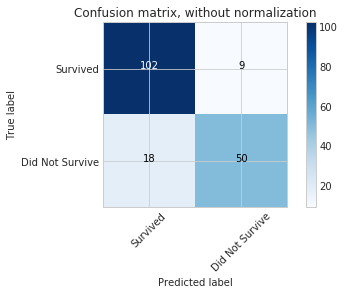

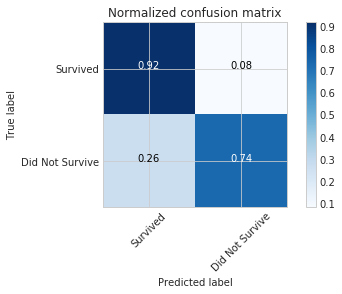

In [37]:

# It looks like our model can predict with about 80%-85% accuracty whether or not a given
# passenger survived the sinking of the Titanic.  That is pretty good!

# Now let's evaluate our predictions by making a confusion matrix
# To learn more about this confusion matrix, see the following documentation:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

# First Make a Prediction
from sklearn.metrics import confusion_matrix
import itertools
model = votingC
model.fit(X_train, Y_train)
prediction = model.predict(X_test)

# Now plot the confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, prediction)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
class_names = ["Survived", "Did Not Survive"]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()



In [38]:


# It looks like when we make an error, the error tends to be to predict "did not survive" 
# for someone who actually did survive.  So there is still room for improvement.
# But for now, I am satisfied with the performance of our current models.
# After all, the sinking of the Titanic was a very chaotic event.
# Next we will make and submit our predictions using the test dataset.
# You should expect to get around 80% accuracy.


#	TABLE OF CONTENTS 
    #b.	Part Two: 80% Accuracy with an Expanded Dataset
        #i.	Load Data
        #ii.	Process Data
        #iii.	Engineer Data
        #iv.  Select Features 
        #v.	Make Predictions 


# Submission with Ensemble Voting Classification Method

# Load testing Data (to extract PassengerID Only)
#testingData2 = pd.read_csv('test.csv')
testingData2 = pd.read_csv('../input/test.csv')
# Define Model, Predict, Submitmodel = votingC
model = votingC
model.fit(X_train, Y_train)
prediction = model.predict(testingData)
prediction = prediction.astype(int)
submission = pd.DataFrame({
    "PassengerId": testingData2["PassengerId"],
    "Survived": prediction})
submission.to_csv('_new_submission_ensemble.csv', index=False)

# to finish the submission process, upload the file '_new_submission_.csv' to Kaggle


#_Alternative Submission for Keras

# Re-Load testing Data (to extract PassengerID Only)
#testingData2 = pd.read_csv('test.csv')
testingData2 = pd.read_csv('../input/test.csv')
# Define Model, Predict, Submit
model = kerasModelTwo
model.fit(np.array(X_train), np.array(Y_train), epochs=50, verbose=2, validation_split=0.2)
prediction = model.predict_classes(np.array(testingData))
submission = pd.DataFrame({"PassengerId": testingData2["PassengerId"], "Survived": prediction.flatten()})
submission.to_csv('_new_submission_Keras.csv', index=False)

# to finish the submission process, upload the file '_new_submission_.csv' to Kaggle

# Submission with LinearSVC

# Load testing Data (to extract PassengerID Only)
#testingData2 = pd.read_csv('test.csv')
testingData2 = pd.read_csv('../input/test.csv')
# Define Model, Predict, Submitmodel = votingC
model = LinearSVC(C=0.0001, class_weight=None, dual=True, fit_intercept=True,intercept_scaling=1, loss='squared_hinge', max_iter=1000,multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,verbose=0)
model.fit(X_train, Y_train)
prediction = model.predict(testingData)
prediction = prediction.astype(int)
submission = pd.DataFrame({
    "PassengerId": testingData2["PassengerId"],
    "Survived": prediction})
submission.to_csv('_new_submission_LinearSVC.csv', index=False)

# to finish the submission process, upload the file '_new_submission_.csv' to Kaggle



Train on 569 samples, validate on 143 samples
Epoch 1/50
0s - loss: 0.5076 - acc: 0.7961 - val_loss: 0.4609 - val_acc: 0.7972
Epoch 2/50
0s - loss: 0.5007 - acc: 0.7786 - val_loss: 0.4609 - val_acc: 0.8042
Epoch 3/50
0s - loss: 0.5047 - acc: 0.7944 - val_loss: 0.4389 - val_acc: 0.8462
Epoch 4/50
0s - loss: 0.4786 - acc: 0.8172 - val_loss: 0.4866 - val_acc: 0.8042
Epoch 5/50
0s - loss: 0.4970 - acc: 0.8102 - val_loss: 0.4350 - val_acc: 0.8462
Epoch 6/50
0s - loss: 0.4891 - acc: 0.8067 - val_loss: 0.4308 - val_acc: 0.8462
Epoch 7/50
0s - loss: 0.4704 - acc: 0.8084 - val_loss: 0.4295 - val_acc: 0.8462
Epoch 8/50
0s - loss: 0.4773 - acc: 0.8067 - val_loss: 0.4515 - val_acc: 0.8392
Epoch 9/50
0s - loss: 0.4877 - acc: 0.8190 - val_loss: 0.4500 - val_acc: 0.8392
Epoch 10/50
0s - loss: 0.4793 - acc: 0.8137 - val_loss: 0.4413 - val_acc: 0.8462
Epoch 11/50
0s - loss: 0.4872 - acc: 0.8067 - val_loss: 0.4287 - val_acc: 0.8462
Epoch 12/50
0s - loss: 0.4398 - acc: 0.8225 - val_loss: 0.4279 - val_acc